# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType,FloatType
# ML imports
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler
from pyspark.ml.feature import StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# TO load saved models 
from pyspark.ml.tuning import CrossValidatorModel as mlm

import numpy as np
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# create a Spark session
spark=SparkSession \
.builder \
.appName("Sparkify") \
.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
data="mini_sparkify_event_data.json"
df=spark.read.json(data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [6]:
df.count()

286500

In [7]:
df = df.dropna(how='any',subset=['userId','sessionId'])
df.count()

286500

In [8]:
df = df.filter(df.userId!="")
df.count()

278154

# Exploratory Data Analysis

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.
### Explore Data

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

See different pages


In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Let's see one user who canceled the premium

In [11]:
df.filter(df.page=='Cancellation Confirmation').select('userId').dropDuplicates().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [12]:
#add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [13]:
df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "100014").sort("time").show(100)

+------+---------------+-------------------+-----+--------------------+---------+
|userId|           page|               time|level|                song|sessionId|
+------+---------------+-------------------+-----+--------------------+---------+
|100014|       NextSong|2018-10-10 13:12:16| paid|Welcome To The Wo...|       37|
|100014|       NextSong|2018-10-10 13:15:51| paid|              Odessa|       37|
|100014|       NextSong|2018-10-10 13:17:56| paid|             Amapola|       37|
|100014|       NextSong|2018-10-10 13:21:38| paid|Exogenesis: Symph...|       37|
|100014|           Help|2018-10-10 13:21:45| paid|                null|       37|
|100014|       NextSong|2018-10-10 13:25:56| paid|       Sehr kosmisch|       37|
|100014|       NextSong|2018-10-10 13:36:51| paid|     Moghram Ya Lail|       37|
|100014|       NextSong|2018-10-10 13:41:54| paid|   AtrÃÂ©vete te te|       37|
|100014|       NextSong|2018-10-10 13:45:53| paid|             Forever|       37|
|100014|       N

#### Add the churn colurmn in df

In [14]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

In [15]:
#churn_users.collect()

Show the gender distribution between churn user and normal user

In [16]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



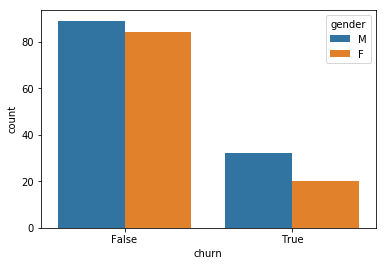

In [17]:
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

Show the page use distribution between churn user and normal user

In [18]:
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

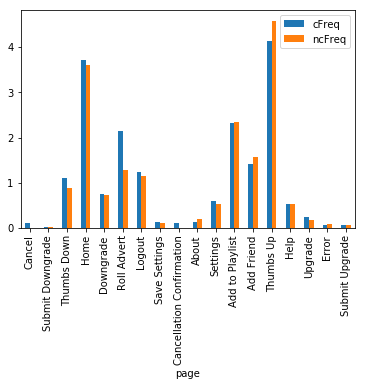

In [19]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

Show the level when the user churned

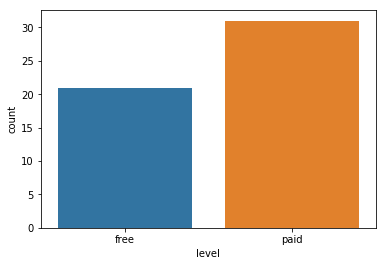

In [20]:
df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

In [21]:
df_pd

,level,count
0,free,21
1,paid,31


Show the time span of the log

In [23]:
df_withchurn.select("time").describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



Show the distribution in operations in each session

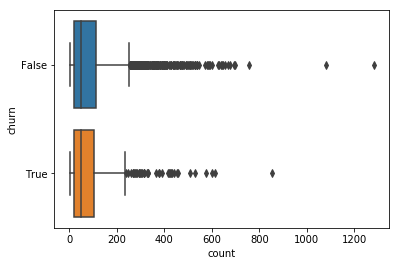

In [24]:
df_pd = df_withchurn.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)

Time distribution

In [25]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", get_day(df_withchurn.ts))

In [26]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='green', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='blue', label='Churn')

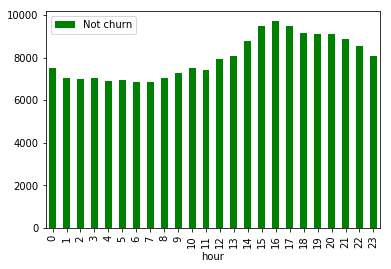

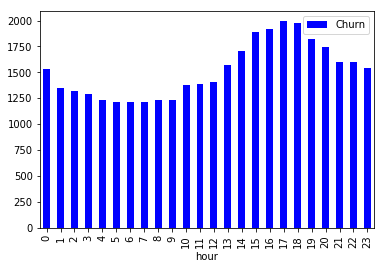

In [27]:
plot_cnt_by_churn("hour")

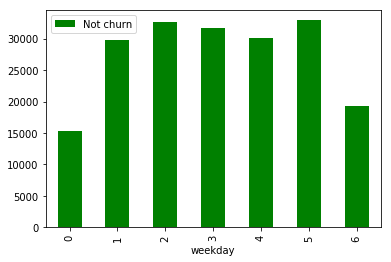

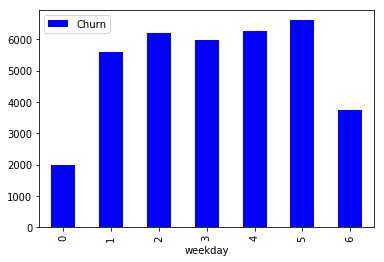

In [28]:
plot_cnt_by_churn("weekday")

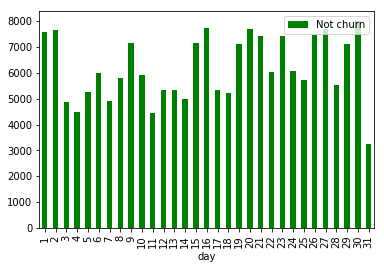

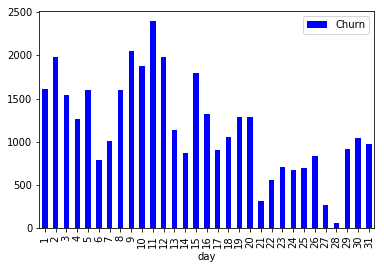

In [29]:
plot_cnt_by_churn('day')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Overview

There are many featurs to keep,

   1. Categoric features 1needs to be converted to numeric form through dummi encoding)
            a.Gender of user
            b.The user's OS os_specific
            c.(may be) the state he/she lives in
            d.The payment level (Paid/Free)
            e.(may be) the top artist the user listined to.

   2. Numeric features
            a.Song length per user per session
            b.Number of ThumbsUp
            c.Number of ThumbsDown
            d.Number of InviteFriends
            e.Number of downgrades
            f.Number of songs per session
            g.Number of artists the user fans
            h.Session's duration
            i.Sessions' count per user
            j.The user's subscription age
            k.Number of days as free/paid user

First of all we should create a table of chorn/ not chorn users, as the base of ML dataset

Feature 1: number of days since registration

In [30]:
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [31]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



In [32]:
churn_users = df_withchurn.select('userId', 'churn').dropDuplicates()
# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|    19|false|
|100005| true|
|200007|false|
|300007| true|
|    50|false|
|200002|false|
|    30|false|
|     8|false|
|100011| true|
|100012| true|
+------+-----+
only showing top 10 rows



Feature 2: avg & min & max time per session

In [33]:
user_session_time = df_withchurn.groupby("userId", "sessionId")\
.agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))

user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), 
min(user_session_time.sessionTime).alias("minSessionTime"),
max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [34]:
user_session_time_stat.show(5)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows



Feature 3: number of songs per session

In [35]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()

user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [36]:
user_session_songs.show(10)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
|   101|      635|  708|
|   120|      627|  236|
|   140|      798|    3|
|   122|      691|    6|
|    29|     1030|   13|
|     8|     1200|   11|
|    96|     1653|  133|
|   153|     1794|   62|
+------+---------+-----+
only showing top 10 rows



Feature 4: number of sessions

In [37]:
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()

user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

In [38]:
user_session_count.show(10)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
|     7|           7|
|    54|          37|
|    15|          15|
|   155|           6|
|100014|           6|
+------+------------+
only showing top 10 rows



Feature 5: gender

In [39]:
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

user_gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
+------+------+
only showing top 10 rows



Feature 6: whether the user is currently a paid user

In [40]:
user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")

user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))

user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")

user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")

user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

user_recent_level.show(10)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
+------+-----+
only showing top 10 rows



Feature 7: frequency of use of pages

In [41]:
# get all the type of page
page_list = [(row['page']) for row in df_withchurn.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = df_withchurn.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")


for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = df_withchurn.filter(df_withchurn.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [43]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [44]:
user_page_view_freq.show(5)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+----------------

Feature 8: how many singers have the user heard

In [45]:
user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")

user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



Label: churn

In [46]:
user_churn = df_withchurn.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [47]:
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



Put all the features into a dataframe

In [48]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [49]:
# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId").dropDuplicates()

In [50]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [51]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)


In [52]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+------------------+------------------+-----------------+------------------+------------------+------------+------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|aritstCount|churn|
+------+------------------+-------------


Saving the dataframe for future access in another session

In [53]:
# Saving as SPARK format
df_final.write.save('saved_user_dataset.CSV', format='csv', header=True)

And a pandas dataset as well

In [54]:
final_dfp = df_final.toPandas()
final_dfp.head(10)

,userId,regDay,avgSessionTime,minSessionTime,maxSessionTime,avgSessionSongs,sessionCount,gender,level,freqSubmitDowngrade,...,freqAddtoPlaylist,freqAddFriend,freqNextSong,freqThumbsUp,freqHelp,freqUpgrade,freqError,freqSubmitUpgrade,aritstCount,churn
0,10,51.762650,459.747222,91.416667,1547.916667,112.166667,6,0,1,0.000000,...,1.132075,1.509434,84.654088,4.654088,0.125786,0.000000,0.000000,0.000000,565,0
1,100,64.873773,316.519048,0.000000,1019.583333,78.882353,35,0,1,0.031114,...,1.897946,1.524580,83.447418,4.604854,0.560050,0.031114,0.093342,0.031114,1705,0
2,100001,44.800220,148.158333,63.000000,215.283333,33.250000,4,1,0,0.000000,...,1.604278,1.069519,71.122995,4.278075,0.534759,1.069519,0.534759,0.000000,125,1
3,100002,160.472072,201.183333,0.000000,730.466667,48.750000,4,1,1,0.000000,...,2.293578,0.458716,89.449541,2.293578,0.000000,0.000000,0.000000,0.000000,184,0
4,100003,22.748113,99.116667,3.216667,195.016667,25.500000,2,1,0,0.000000,...,2.564103,0.000000,65.384615,3.846154,1.282051,0.000000,0.000000,0.000000,50,1
5,100004,172.440081,185.986508,0.000000,940.216667,47.100000,21,1,1,0.160643,...,1.847390,1.526104,75.662651,2.811245,0.481928,0.642570,0.160643,0.240964,733,0
6,100005,85.195590,120.186667,0.000000,209.216667,38.500000,5,0,0,0.000000,...,1.388889,1.388889,71.296296,3.240741,0.925926,1.851852,0.000000,0.000000,149,1
7,100006,9.127164,93.433333,93.433333,93.433333,26.000000,1,1,0,0.000000,...,2.272727,9.090909,59.090909,4.545455,0.000000,0.000000,0.000000,0.000000,26,1
8,100007,115.387616,189.411111,8.900000,675.633333,47.000000,9,1,1,0.000000,...,1.730769,3.269231,81.346154,3.653846,0.576923,0.000000,0.000000,0.000000,357,1
9,100008,68.228565,528.252778,57.050000,2024.400000,128.666667,6,1,0,0.106383,...,3.191489,1.808511,82.127660,3.936170,0.638298,0.425532,0.000000,0.000000,623,0


In [55]:
final_dfp.to_csv('saved_user_dataset_pd.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Loading and adjusting data

In [56]:
final_df = spark.read.csv('saved_user_dataset.CSV', header = True)
pfinal_df = final_df.toPandas()
pfinal_df.head()

,userId,regDay,avgSessionTime,minSessionTime,maxSessionTime,avgSessionSongs,sessionCount,gender,level,freqSubmitDowngrade,...,freqAddtoPlaylist,freqAddFriend,freqNextSong,freqThumbsUp,freqHelp,freqUpgrade,freqError,freqSubmitUpgrade,aritstCount,churn
0,30,63.06664351851852,183.5942708333333,0.0,1089.0333333333333,50.607142857142854,32,0,1,0.056338028169014086,...,2.647887323943662,1.408450704225352,79.83098591549296,3.492957746478873,0.28169014084507044,0.7887323943661971,0.056338028169014086,0.056338028169014086,1018,0
1,300001,188.3117824074074,382.05263157894734,0.0,1418.25,102.88235294117646,19,1,1,0.0,...,3.1826568265682655,1.3837638376383763,80.67343173431735,6.826568265682657,0.507380073800738,0.09225092250922509,0.13837638376383765,0.046125461254612546,1201,1
2,200008,115.18381944444444,452.27555555555557,17.183333333333334,1206.3833333333334,111.26666666666667,15,1,1,0.0,...,2.2365805168986084,1.341948310139165,82.95228628230616,3.379721669980119,0.19880715705765406,0.049701789264413515,0.14910536779324055,0.049701789264413515,1159,0
3,200009,58.83949074074074,267.12111111111113,0.0,783.65,64.2,15,0,0,0.08347245409015025,...,2.2537562604340566,1.669449081803005,80.38397328881469,3.4223706176961604,0.5843071786310517,0.08347245409015025,0.0,0.08347245409015025,746,0
4,10,51.76265046296297,459.74722222222226,91.41666666666667,1547.9166666666667,112.16666666666667,6,0,1,0.0,...,1.1320754716981132,1.5094339622641508,84.65408805031447,4.654088050314465,0.12578616352201258,0.0,0.0,0.0,565,0


In [57]:
final_df.persist()

DataFrame[userId: string, regDay: string, avgSessionTime: string, minSessionTime: string, maxSessionTime: string, avgSessionSongs: string, sessionCount: string, gender: string, level: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, aritstCount: string, churn: string]

In [58]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- regDay: string (nullable = true)
 |-- avgSessionTime: string (nullable = true)
 |-- minSessionTime: string (nullable = true)
 |-- maxSessionTime: string (nullable = true)
 |-- avgSessionSongs: string (nullable = true)
 |-- sessionCount: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- freqSubmitDowngrade: string (nullable = true)
 |-- freqThumbsDown: string (nullable = true)
 |-- freqHome: string (nullable = true)
 |-- freqDowngrade: string (nullable = true)
 |-- freqRollAdvert: string (nullable = true)
 |-- freqLogout: string (nullable = true)
 |-- freqSaveSettings: string (nullable = true)
 |-- freqAbout: string (nullable = true)
 |-- freqSettings: string (nullable = true)
 |-- freqAddtoPlaylist: string (nullable = true)
 |-- freqAddFriend: string (nullable = true)
 |-- freqNextSong: string (nullable = true)
 |-- freqThumbsUp: string (nullable = true)
 |-- freqHelp: string (nullabl

In [59]:
# Change the column names to strings without spaces
for col in final_df.columns:
    final_df = final_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(final_df.columns)

['userId', 'regDay', 'avgSessionTime', 'minSessionTime', 'maxSessionTime', 'avgSessionSongs', 'sessionCount', 'gender', 'level', 'freqSubmitDowngrade', 'freqThumbsDown', 'freqHome', 'freqDowngrade', 'freqRollAdvert', 'freqLogout', 'freqSaveSettings', 'freqAbout', 'freqSettings', 'freqAddtoPlaylist', 'freqAddFriend', 'freqNextSong', 'freqThumbsUp', 'freqHelp', 'freqUpgrade', 'freqError', 'freqSubmitUpgrade', 'aritstCount', 'churn']


In [60]:
# Convert all to numbers as the schema shows strings
# the first column (userId) would be integer
final_df = final_df.withColumn('userId', final_df.userId.cast(IntegerType()))

# All other columns should be float
for col in final_df.columns[1:]:
    final_df = final_df.withColumn(col, final_df[col].cast(FloatType()))

final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- regDay: float (nullable = true)
 |-- avgSessionTime: float (nullable = true)
 |-- minSessionTime: float (nullable = true)
 |-- maxSessionTime: float (nullable = true)
 |-- avgSessionSongs: float (nullable = true)
 |-- sessionCount: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- level: float (nullable = true)
 |-- freqSubmitDowngrade: float (nullable = true)
 |-- freqThumbsDown: float (nullable = true)
 |-- freqHome: float (nullable = true)
 |-- freqDowngrade: float (nullable = true)
 |-- freqRollAdvert: float (nullable = true)
 |-- freqLogout: float (nullable = true)
 |-- freqSaveSettings: float (nullable = true)
 |-- freqAbout: float (nullable = true)
 |-- freqSettings: float (nullable = true)
 |-- freqAddtoPlaylist: float (nullable = true)
 |-- freqAddFriend: float (nullable = true)
 |-- freqNextSong: float (nullable = true)
 |-- freqThumbsUp: float (nullable = true)
 |-- freqHelp: float (nullable = true)
 |-- freqUp

In [61]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

final_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- regDay: float (nullable = true)
 |-- avgSessionTime: float (nullable = true)
 |-- minSessionTime: float (nullable = true)
 |-- maxSessionTime: float (nullable = true)
 |-- avgSessionSongs: float (nullable = true)
 |-- sessionCount: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- level: float (nullable = true)
 |-- freqSubmitDowngrade: float (nullable = true)
 |-- freqThumbsDown: float (nullable = true)
 |-- freqHome: float (nullable = true)
 |-- freqDowngrade: float (nullable = true)
 |-- freqRollAdvert: float (nullable = true)
 |-- freqLogout: float (nullable = true)
 |-- freqSaveSettings: float (nullable = true)
 |-- freqAbout: float (nullable = true)
 |-- freqSettings: float (nullable = true)
 |-- freqAddtoPlaylist: float (nullable = true)
 |-- freqAddFriend: float (nullable = true)
 |-- freqNextSong: float (nullable = true)
 |-- freqThumbsUp: float (nullable = true)
 |-- freqHelp: float (nullable = true)
 |-- freqUp

In [62]:
# Remove  nulls from anywhere replacing them by zeros
final_df = final_df.na.fill(0)

In [63]:
# Get features labels for plotting purposes
features_labels = final_df.columns[1:-1]

In [64]:
# The input features are all but the userId and the Churn
# The output is Churn only

# Define the vector assembler for all input columns
features_vector = VectorAssembler(inputCols=final_df.columns[1:-1], outputCol='features')

# Apply the vectorization on the dataset
input_data = features_vector.transform(final_df)
# input_data.show(1)

In [65]:
features_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scaler_fit = features_scaler.fit(input_data)
scaled_inputs = features_scaler_fit.transform(input_data)

In [66]:
# Select the output and input features
ml_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [67]:
# Defining training and testing samples
train, test = ml_data.randomSplit([0.80, 0.20], seed=179)

train.show(3), test.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[-1.3934804265523...|
|  0.0|[-1.2959147430091...|
|  0.0|[-0.7456701449130...|
+-----+--------------------+
only showing top 3 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[-0.5577635283439...|
|  0.0|[-0.3380652949508...|
|  0.0|[-0.3084617257473...|
+-----+--------------------+
only showing top 3 rows



(None, None)

Defining important functions for outputs and alalysis

In [68]:
def format_duration (t_dif):
    t_s = t_dif.seconds
    duration = {}
    duration['h'], rem = divmod(t_s, 3600) 
    duration['m'], duration['s'] = divmod(rem, 60)
    stamp = ''
    if duration['h']>0:
        stamp += f"{duration['h']} hour(s), " 
    if duration['m']>0:
        stamp += f"{duration['m']} minute(s) and "
    # seconds and fraction of seconds
    frac = int(t_dif.microseconds/10000)/100
    stamp += f"{duration['s'] + frac} second(s)"
    # print(f"{duration['h']}h:{duration['m']}m:{duration['s']}s")
    return stamp

In [69]:
def model_fitting(data, model_type, param_grid, save_as, num_folds=3, random_seed=179):
    '''
    Train the any model with passing there parameter and save the model with model name.
    
    '''
    model_evaluator = CrossValidator(estimator=model_type, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=num_folds, seed=random_seed)
    t_start = pd.tslib.Timestamp.now()
    print ('Fitting in progress...', end=' ')
    fitted_model = model_evaluator.fit(data)
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    t_start = pd.tslib.Timestamp.now()
    print (f'\nSaving the model as {save_as}...' , end=' ')
    try:
        fitted_model.save(save_as)
    except:
        # Overwrite if exists
        fitted_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
    t_dif = pd.tslib.Timestamp.now() - t_start
    print (f'Done in {format_duration(t_dif)}')
    return fitted_model

In [70]:
def get_formated_metrics(selected_model, test_data):
    '''
    Prints a compacted dataframe with all the model's metrics
    selected_model: The fitted model
    test_data: the test data portion
    '''
    def get_model_metrics(selected_model, model_type = 'train'):
        '''
        Get the metrics of a model
        selected_model:  the fitted model
        model_type: either 'train' (default) or 'test'
        '''
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
        else: 
            metrics = selected_model
        acc = metrics.accuracy, 
        general = np.array((metrics.weightedFMeasure(),
                   metrics.weightedPrecision, metrics.weightedRecall,
                   metrics.weightedTruePositiveRate, metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labeled = np.array((metrics.fMeasureByLabel(),
                          metrics.precisionByLabel, metrics.recallByLabel,
                          metrics.truePositiveRateByLabel, metrics.falsePositiveRateByLabel))
        conc_results = np.concatenate((general.T, labeled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_+ve_Rate', 'False_+ve_Rate']
        df_res = pd.DataFrame(conc_results, columns=labels, index=metrics_names)
        return acc[0], df_res
    
    # Apply for training data
    acc_train, train_res = get_model_metrics(selected_model)
    # Get the results of the test data
    model_test = selected_model.bestModel.evaluate(test_data)
    # Apply on test data
    acc_test, test_res = get_model_metrics(model_test, model_type='test')
    
    # Concatenate to a pretty dataframe
    pretty_frame = pd.concat([train_res, test_res], axis=1, keys=[
                    f'Training (Accuracy = {acc_train*100:4.2f}%)',
                    f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    return pretty_frame

In [71]:
def draw_features_contribution(fitted_model, x_labels, scale_to='full_range'):
    '''
    Draws a bar chart of features vs churn %
    fitted_model: the fitted model
    scale_to: the values will be scated to:
           'full_range' where the full absolute values are summed to 100.
           'maximum_range' where the maximum absolute extremes are scalled to 100.
           'none' the values are shown as is.
    '''
    cmx = fitted_model.bestModel.coefficientMatrix
    cmv = cmx.values
    # cmv.shape, len(final_df.columns[2:])
    
    # Define positive and negative values
    positives_v = np.array([x if x>=0 else 0 for x in cmv])
    negatives_v = np.array([x if x<=0 else 0 for x in cmv])    
    
    # Drawing by scalling the maximum range to  100
    if scale_to == 'full_range':
        rang = positives_v.sum()+ abs(negatives_v).sum()
    elif scale_to == 'maximum_range':
        rang = positives_v.max()+ abs(negatives_v).max()
    else:
        rang = 1.
        
    positives_v /= rang
    negatives_v /= rang
    positives_v *= 100.
    negatives_v *= 100.
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positives_v,color='r')
    ax.bar(x_labels, negatives_v, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('The user is most likely to churn (%)')
    ax.set_title('Contribution of each feature to the churn decission')
    ax.set_xticklabels(labels = final_df.columns[2:], rotation='vertical');


In [72]:
def get_classifier_metrics(trained_model, train_data, test_data):
    '''
    
    '''
    def get_specific_metrics(trained_model, data):
        '''
        
        '''
        res2 = trained_model.transform(data).select('label', 'prediction')
        TruePos = res2.filter((res2.prediction==1)& (res2.label == res2.prediction) ).count()
        TrueNeg = res2.filter((res2.prediction==0)& (res2.label == res2.prediction) ).count()
        FalsPos = res2.filter((res2.prediction==1)& (res2.label != res2.prediction) ).count()
        FalsNeg = res2.filter((res2.prediction==0)& (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = TruePos/(TruePos+FalsPos)
        recall = TruePos/(TruePos+FalsNeg)
        f1score = 2 * precision * recall / (precision + recall)
        return accuracy, precision, recall, f1score
    train_metrics = get_specific_metrics(trained_model, train_data)
    test_metrics = get_specific_metrics(trained_model, test_data)
    labels =['Train', 'Test']
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F-Score']
    metrics_data =np.array((train_metrics, test_metrics))
    return pd.DataFrame(data=metrics_data.T, columns=labels, index=metrics_names)


In [73]:
def draw_features_importance(fitted_model, x_labels, threshold=0.1):
    '''
    Draws a pie chart of features
    fitted_model: the fitted model
    x_labels: the labels of the features.
    threshold: the minimum value (%) to consider, 
               if the value is less than that, 
               it will be neglected (default =0)
    '''
    importance = list(fitted_model.bestModel.featureImportances.toArray())
    # Get the threshold value
    thres_v = threshold / 100 
    # get the included and neglected values
    active_values = [x for x in importance if x >= thres_v]
    neglected = [x for x in importance if x < thres_v]
    non_zero_neglected = [x for x in neglected if x > 0]
    # print(importance, '\n', x_labels, '\n', thres_v, '\n', 
    #       active_values, '\n', neglected, '\n', non_zero_neglected)
    # get the accepted indexes
    active_idx = [importance.index(x) for x in active_values]
    # the accepted lables + minor features
    active_labels = [x_labels[x] for x in active_idx]
    minor_v = sum(neglected)
    # print(active_idx, '\n', active_labels, '\n', minor_v)
    # If there is any minor features
    if minor_v>0:
        active_values.append(minor_v)
        active_labels.append(f'MINOR, ({len( \
                non_zero_neglected)}feats. each<{threshold}%)')
    # print(active_labels, '\n', active_values)
    
    # sorting
    active_labels =[x for _, x in sorted(zip(active_values, active_labels))]
    active_values = sorted(active_values)
    
    # Draw

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active_values[::-1], labels=active_labels[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Importance of each feature to the churn decission')
    ax.axis('equal');



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if __name__ == '__main__':


Fitting in progress... Done in 2 minute(s) and 6.3 second(s)

Saving the model as LogisticRegression.model... Done in 1.51 second(s)


Training (Accuracy = 88.14%)                      \
                                    General Churn=0.0 Churn=1.0   
F-Measure                          0.868265  0.928328  0.655738   
Precision                          0.884398  0.877419  0.909091   
Recall                             0.881356  0.985507  0.512821   
True_+ve_Rate                      0.881356  0.985507  0.512821   
False_+ve_Rate                     0.383028  0.487179  0.014493   

               Testing (Accuracy = 75.00%)                      
                                   General Churn=0.0 Churn=1.0  
F-Measure                         0.722368  0.842105  0.400000  
Precision                         0.723868  0.780488  0.571429  
Recall                            0.750000  0.914286  0.307692  
True_+ve_Rate                     0.750000  0.914286  0.307692  
False_+ve_Rate                    0.528022  0.692308  0.085714

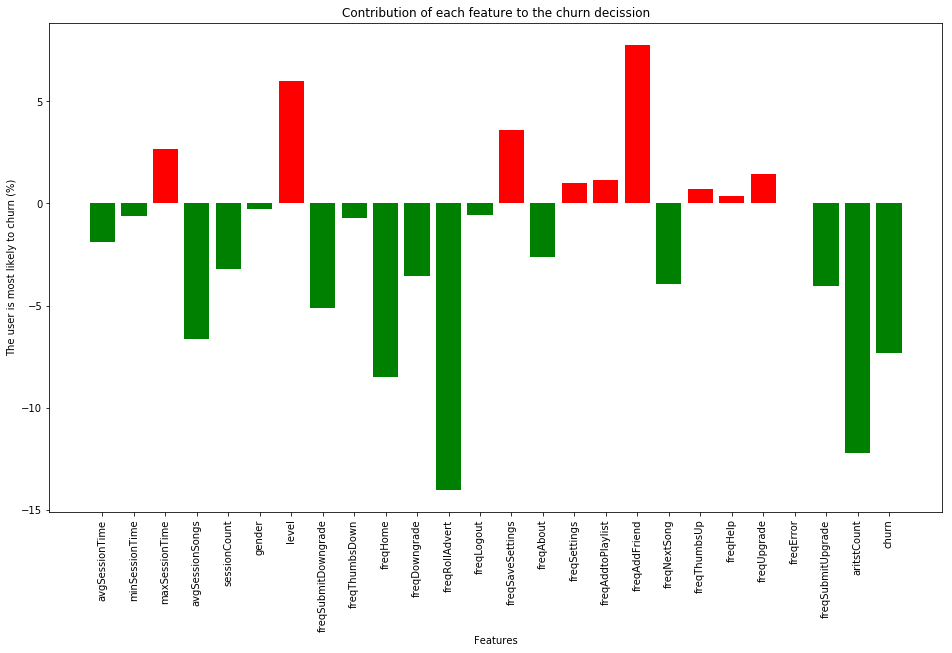

In [74]:
# The Logistic Regression model

model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()
# param_grid = ParamGridBuilder() \
#     .addGrid(model.aggregationDepth,[2, 5]) \
#     .build()
m = model_fitting(train, model, param_grid, 'LogisticRegression.model')
# Model metrics
display(get_formated_metrics(m, test))
# Features effect
draw_features_contribution(m, x_labels=features_labels)



The Decision Tree Classifier model

In [75]:
# The Decision Tree Classifier model

model = DecisionTreeClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .build()

m = model_fitting(train, model, param_grid, 'DecisionTreeClassifier.model')


Fitting in progress... Done in 29.77 second(s)

Saving the model as DecisionTreeClassifier.model... Done in 0.68 second(s)


In [76]:
# to load the model from saved location
m = mlm.load('DecisionTreeClassifier.model')

In [77]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.898305,0.729167
Precision,0.862069,0.500000
Recall,0.641026,0.384615
F-Score,0.735294,0.434783


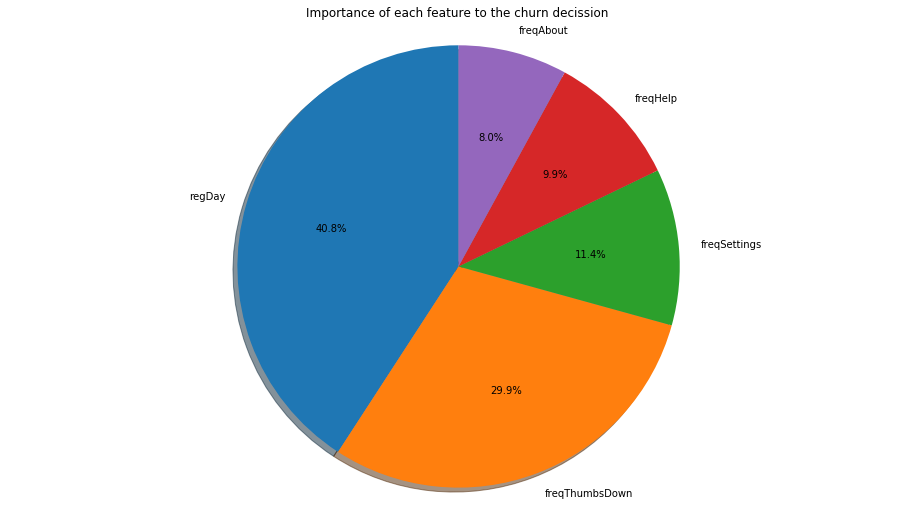

In [78]:
draw_features_importance(m, features_labels, threshold=3)

The Gradient-Boosted Trees (GBTs) model

In [79]:
# The Gradient-Boosted Trees (GBTs) model

model = GBTClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[3, 5, 10]) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.maxIter ,[20, 5]) \
    .build()

m = model_fitting(train, model, param_grid, 'GradientBoostedTrees.model')

Fitting in progress... Done in 5 minute(s) and 18.48 second(s)

Saving the model as GradientBoostedTrees.model... Done in 1.16 second(s)


In [80]:
# to load the model from saved location
m = mlm.load('GradientBoostedTrees.model')

In [81]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.932203,0.729167
Precision,1.000000,0.500000
Recall,0.692308,0.384615
F-Score,0.818182,0.434783


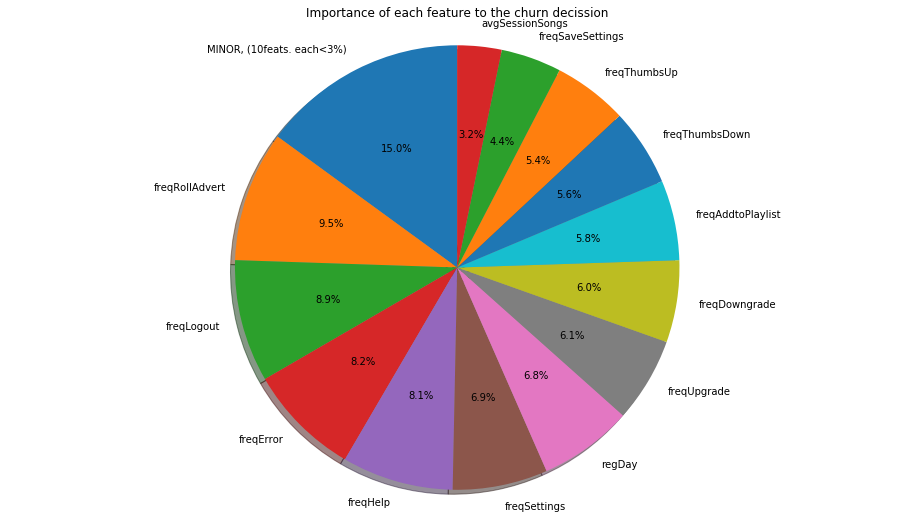

In [82]:
draw_features_importance(m, features_labels, threshold=3)

In [83]:
# The Random Forest model

model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[5, 10]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins ,[10, 5]) \
    .addGrid(model.numTrees ,[20, 10]) \
    .addGrid(model.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

m = model_fitting(train, model, param_grid, 'RandomForestClassifier.model')

Fitting in progress... Done in 2 minute(s) and 20.05 second(s)

Saving the model as RandomForestClassifier.model... Done in 0.95 second(s)


In [84]:
# to load the model from saved location
m = mlm.load('RandomForestClassifier.model')

In [85]:
# Show metrics
display(get_classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.915254,0.750000
Precision,0.961538,0.666667
Recall,0.641026,0.153846
F-Score,0.769231,0.250000


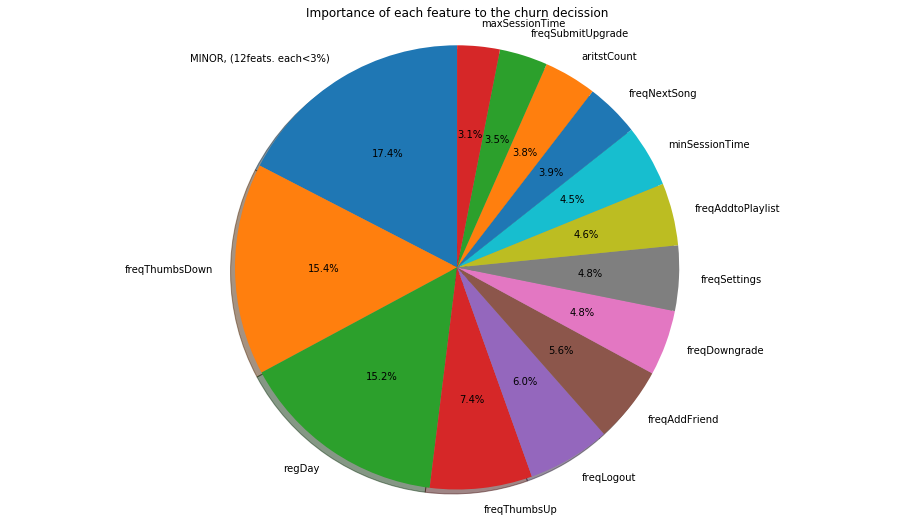

In [86]:
draw_features_importance(m, features_labels, threshold=3)



maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', numTrees=20, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0

## The NaiveBayes model

class pyspark.ml.classification.NaiveBayes(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', rawPredictionCol='rawPrediction', smoothing=1.0, modelType='multinomial', thresholds=None, weightCol=None)[source]¶


In [88]:
# The NaiveBayes model

# model = NaiveBayes()
# param_grid = ParamGridBuilder() \
#     .addGrid(model.smoothing ,[0.5, 1.0, 1.7, 3.0]) \
#     .addGrid(model.modelType ,['multinomial', 'bernoulli']) \
#     .build()

# m = model_fitting(train, model, param_grid, 'NaiveBayes.model')


FAILED (not suitable due to data nature)

Naive Bayes requires nonnegative feature values but the features vector contains negative values!


## Conclusion

The machine learning modeling succeeded in predicting the customers' activity that will most probably end in unsubscribing. Despite the good results of all the models, the Decision Tree Classifier model appears to be the best here. However, the other models need to be re-adjusted using different settings to reduce the overfitting.

### How to improve the current implementation?

Despite the good results obtained from the current implementation, it is possible to improve the results by doing one or more of the following:

   1. Working with more observations by increasing the dataset size (which is possible in our case by working with the 12GB full dataset)
   2. Trying more parameters of the selected models.
   3. Adding some more features that I believe essential, like the customer location (city/state). The customers of some states appear to have more ability to churn than others; this might be attributed to the nature of life there, some lifestyle profiles force people to be rapidly bored, and thus they like to change the services they use, and trying to try other services. On the other hand, peaceful environment make people settled with what they have and resist change.



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.